In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

tqdm.pandas()

# Data cleaning

## Basic

In [ ]:
df = pd.read_csv("Data/Customers_Orders_Data.csv", low_memory=False)
df.head()

,Unnamed: 0,fsn_id,order_date,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,order_payment_type,sla,cust_id,pincode,product_mrp,product_procurement_sla
0,0,ACCCX3S58G7B5F6P,2023-10-17 15:11:54,3.419301e+15,3.419301e+15,6400,1,\N,\N,COD,5,-1.01299130778588E+018,-7.79175582905735E+018,7190,0
1,1,ACCCX3S58G7B5F6P,2023-10-19 10:07:22,1.420831e+15,1.420831e+15,6900,1,\N,\N,COD,7,-8.99032457905512E+018,7.33541149097431E+018,7190,0
2,2,ACCCX3S5AHMF55FV,2023-10-20 15:45:56,2.421913e+15,2.421913e+15,1990,1,\N,\N,COD,10,-1.0404429420466E+018,-7.47768776228657E+018,2099,3
3,3,ACCCX3S5AHMF55FV,2023-10-14 12:05:15,4.416592e+15,4.416592e+15,1690,1,\N,\N,Prepaid,4,-7.60496084352714E+018,-5.83593163877661E+018,2099,3
4,4,ACCCX3S5AHMF55FV,2023-10-17 21:25:03,4.419525e+15,4.419525e+15,1618,1,\N,\N,Prepaid,6,2.8945572083453E+018,5.34735360997242E+017,2099,3


In [ ]:
df = df.drop(columns = ['Unnamed: 0'])
duplicate_rows = df[df.duplicated()]
df = df.drop_duplicates()
df = df.drop(columns = ['order_id', 'order_item_id', 'deliverybdays', 'deliverycdays', 'cust_id', 'pincode'])

# there is some issue with direct conversion to numbers as gmv has a few empty strings as well
df['gmv'] = df['gmv'].replace(" ", np.nan)
df['gmv'] = pd.to_numeric(df['gmv'])

# total data loss = 4904/1648824 = 0.29%. So instead of imputing it lets drop it to maintain quality of data
df = df.dropna()

# correct the date
df['order_date'] = pd.to_datetime(df['order_date']).dt.date

df['product_procurement_sla'] = df['product_procurement_sla'].abs()

104843

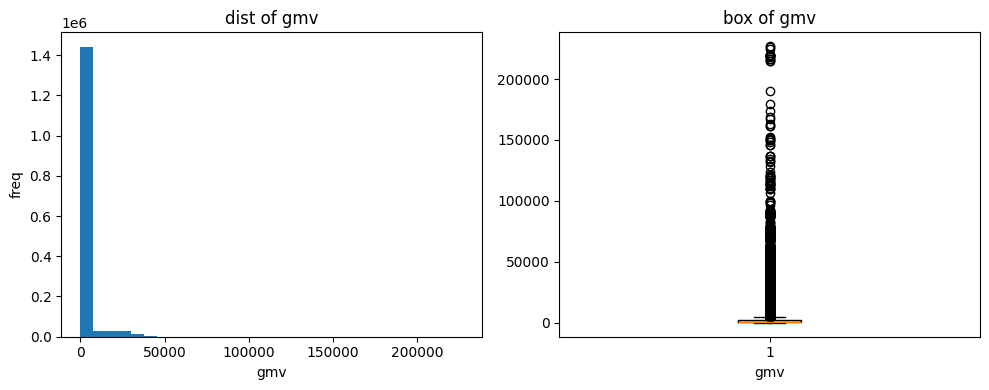

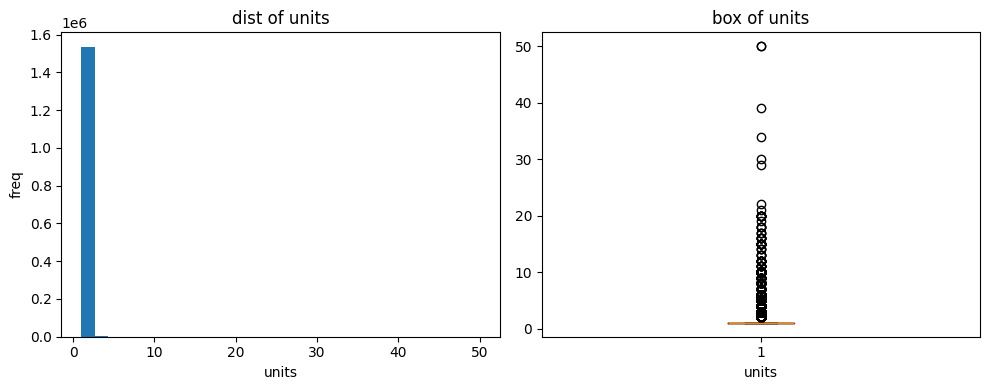

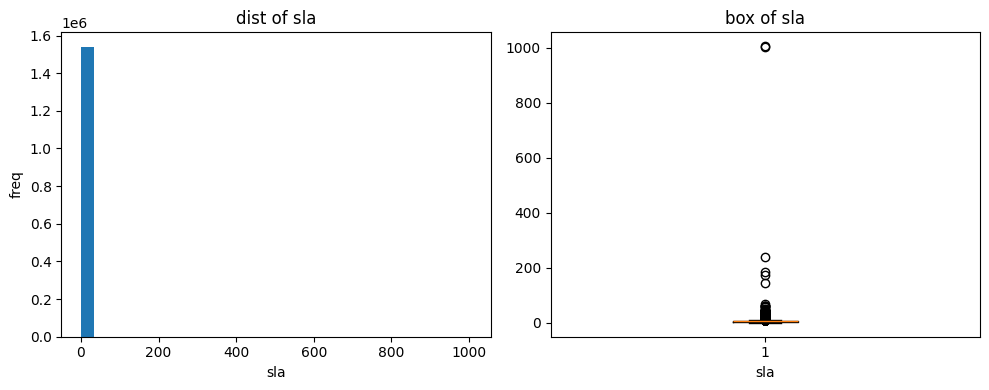

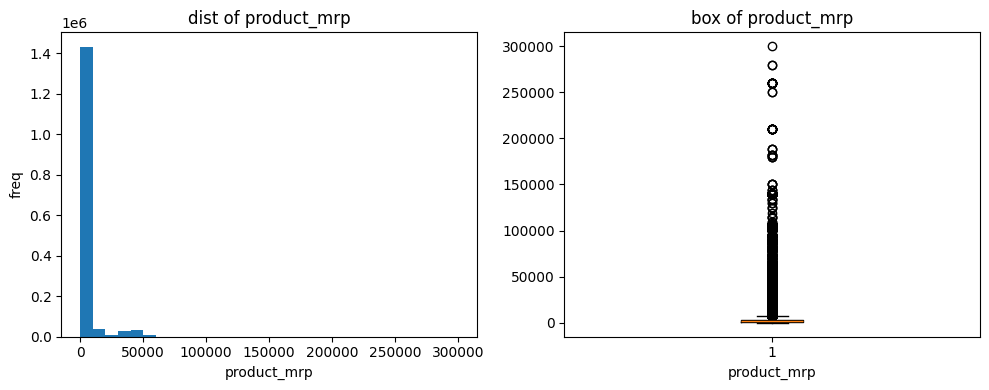

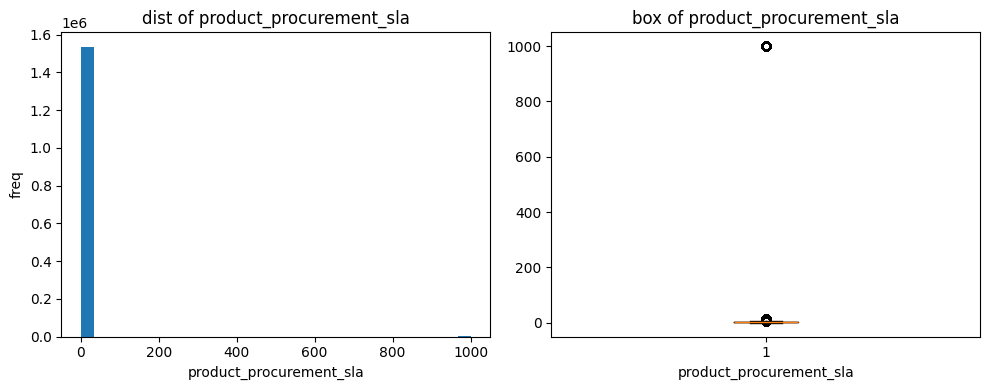

In [ ]:
# distributions

for col in ['gmv', 'units', 'sla', 'product_mrp', 'product_procurement_sla']:

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].hist(df[col], bins=30)
    axes[0].set_title(f'dist of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('freq')

    axes[1].boxplot(df[col].dropna(), vert=True)
    axes[1].set_title(f'box of {col}')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

## Work on order.csv

In [ ]:
df = df.sort_values(by='order_date')

# cutting the down the data to jul'23 to jun'24 since all the other datasets have data for them

df['order_date'] = pd.to_datetime(df['order_date'])

start_date = pd.Timestamp('2023-07-01')
end_date = pd.Timestamp('2024-06-30')

df = df[(df['order_date'] >= start_date) & (df['order_date'] <= end_date)]
df = df.reset_index(drop=True)
df = df.drop(columns = ['order_payment_type'])

df['sla'] = df['sla'] * df['units']
df['product_mrp'] = df['product_mrp'] * df['units']
df['product_procurement_sla'] = df['product_procurement_sla'] * df['units']

df = df.groupby(['order_date', 'fsn_id']).agg({
    'gmv': 'sum',
    'units': 'sum',
    'sla': 'sum',
    'product_mrp': 'sum',
    'product_procurement_sla': 'sum'
}).reset_index()

df['list_price'] = df['gmv'] / df['units']
df['sla'] = df['sla'] / df['units']
df['product_mrp'] = df['product_mrp'] / df['units']
df['product_procurement_sla'] = df['product_procurement_sla'] / df['units']

,fsn_id,order_date,gmv,units,order_payment_type,sla,product_mrp,product_procurement_sla
1376093,ACCDVZ83VBHCWFFA,2023-05-19,3149.0,1,COD,6,6990,4
1436634,VGLE4VR7XSQKYFG7,2023-06-11,275.0,1,COD,8,600,2
1398258,ACCE6VGHYKYFX4WB,2023-06-24,188.0,1,COD,8,310,1
1385002,ACCE2V5DUDZVGFRK,2023-06-25,250.0,1,COD,7,400,4
1358453,ACCDFZEJ6ZGSWRMK,2023-06-26,1119.0,1,COD,28,2500,3


## holidays dataset

In [ ]:
dfh = pd.read_excel('Data/Canada Holiday List.xlsx')

,Occassion,Day
0,Canada Day,"July 1, 2023"
1,Civic Holiday,"August 3, 2023"
2,Labour Day,"September 7, 2023"
3,Thanksgiving,"October 12, 2023"
4,Halloween,"October 31, 2023"


In [ ]:
dfh['Day'] = pd.to_datetime(dfh['Day'])
dfh['Day'] = pd.to_datetime(dfh['Day'])
holiday_dates = dfh['Day'].dt.date.tolist()

df['holiday'] = df['order_date'].dt.date.progress_apply(lambda x: 1 if x in holiday_dates else 0)

df[df['holiday'] == 1]['order_date'].nunique()

,Occassion,Day
0,Canada Day,2023-07-01
1,Civic Holiday,2023-08-03
2,Labour Day,2023-09-07
3,Thanksgiving,2023-10-12
4,Halloween,2023-10-31


## Sales dataset

### media investment dataset

In [ ]:
sheets = pd.read_excel('Data/Media data-Sale Calendar-NPS Scores_Data.xlsx', sheet_name=None)
dfs = list(sheets.values())

dfm, dfs, dfn = dfs # media, sale, nps

# for usability
df['Year'] = df['month_year'].dt.year
df['Month'] = df['month_year'].dt.month

dfm = dfm[2:]

dfm = dfm.drop(columns = dfm.columns[0])
dfm = dfm.apply(pd.to_numeric)
dfm = dfm.fillna(0)

df_ch = df.merge(dfm, on=['Year', 'Month'], how='left')

df = df_ch

### sales days dataset

In [ ]:
sheets = pd.read_excel('Data/Media data-Sale Calendar-NPS Scores_Data.xlsx', sheet_name=None)
dfs = list(sheets.values())

_, dfs, dfn = dfs # media, sale, nps

In [ ]:
dfs = dfs.drop(columns = ['Unnamed: 0'])
dfs = dfs[1:13]
dfs.columns = ['Year', 'Sale Dates']
dfs['Year'] = dfs['Year'].fillna(method='ffill')


,Year,Sale Dates
1,2023.0,(18-19th July)
2,NaN,(15-17th Aug)
3,NaN,(28-30th Aug)
4,NaN,(17-15th Oct)
5,NaN,(7-14th Nov)
6,NaN,(25th Dec'23 - 3rd Jan'24)
7,2024.0,(20-22 Jan)
8,NaN,(1-2 Feb)
9,NaN,(20-21 Feb)
10,NaN,(14-15 Feb)


In [ ]:
dfs = dfs.reset_index(drop=True)

In [ ]:
dfs['sale_start'] = ''
dfs['sale_end'] = ''

for index, row in dfs.iterrows():
    date_str = row['Sale Dates'].strip('()')
    date_str = re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_str)
    year = int(row['Year'])

    # Handle Dec-Jan special case
    if "Dec'23" in date_str and "Jan'24" in date_str:
        dfs.at[index, 'sale_start'] = f"25 Dec 2023"
        dfs.at[index, 'sale_end'] = f"3 Jan 2024"

    # Handle Oct special case (reversed dates)
    elif "Oct" in date_str:
        dfs.at[index, 'sale_start'] = f"15 Oct 2023"
        dfs.at[index, 'sale_end'] = f"17 Oct 2023"

    # Handle regular cases
    else:
        parts = date_str.split('-')

        # Extract start day - ONLY get the digits
        start_day_match = re.search(r'(\d+)', parts[0])
        start_day = start_day_match.group(1) if start_day_match else ""

        # Extract end part
        end_part = parts[1] if len(parts) > 1 else parts[0]

        # Extract end day - ONLY get the digits
        end_day_match = re.search(r'(\d+)', end_part)
        end_day = end_day_match.group(1) if end_day_match else start_day

        # Extract month
        month_match = re.search(r'([A-Za-z]+)', end_part)
        month = month_match.group(1) if month_match else ""

        dfs.at[index, 'sale_start'] = f"{start_day} {month} {year}"
        dfs.at[index, 'sale_end'] = f"{end_day} {month} {year}"

dfs

,Year,Sale Dates,sale_start,sale_end
0,2023.0,(18-19th July),18 July 2023,19 July 2023
1,2023.0,(15-17th Aug),15 Aug 2023,17 Aug 2023
2,2023.0,(28-30th Aug),28 Aug 2023,30 Aug 2023
3,2023.0,(17-15th Oct),15 Oct 2023,17 Oct 2023
4,2023.0,(7-14th Nov),7 Nov 2023,14 Nov 2023
5,2023.0,(25th Dec'23 - 3rd Jan'24),25 Dec 2023,3 Jan 2024
6,2024.0,(20-22 Jan),20 Jan 2024,22 Jan 2024
7,2024.0,(1-2 Feb),1 Feb 2024,2 Feb 2024
8,2024.0,(20-21 Feb),20 Feb 2024,21 Feb 2024
9,2024.0,(14-15 Feb),14 Feb 2024,15 Feb 2024


In [ ]:
dfs = dfs[['sale_start', 'sale_end']]
dfs

,sale_start,sale_end
0,18 July 2023,19 July 2023
1,15 Aug 2023,17 Aug 2023
2,28 Aug 2023,30 Aug 2023
3,15 Oct 2023,17 Oct 2023
4,7 Nov 2023,14 Nov 2023
5,25 Dec 2023,3 Jan 2024
6,20 Jan 2024,22 Jan 2024
7,1 Feb 2024,2 Feb 2024
8,20 Feb 2024,21 Feb 2024
9,14 Feb 2024,15 Feb 2024


In [ ]:
def standardize_date(date_str):
    # Dictionary mapping full month names to abbreviations
    month_map = {
        'January': 'Jan', 'February': 'Feb', 'March': 'Mar', 'April': 'Apr',
        'May': 'May', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
        'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'
    }

    # Use regex to extract day, month, and year
    pattern = r'(\d+)\s+(\w+)\s+(\d{4})'
    match = re.match(pattern, date_str)

    if match:
        day, month, year = match.groups()
        # Convert month to abbreviation if it's a full name
        month_abbr = month_map.get(month, month)
        # Return standardized format
        return f"{day} {month_abbr} {year}"

    return date_str

# Apply standardization to both columns
dfs['sale_start_std'] = dfs['sale_start'].apply(standardize_date)
dfs['sale_end_std'] = dfs['sale_end'].apply(standardize_date)

# Now convert to datetime with a consistent format
dfs['sale_start'] = pd.to_datetime(dfs['sale_start_std'], format="%d %b %Y").dt.strftime('%Y-%m-%d')
dfs['sale_end'] = pd.to_datetime(dfs['sale_end_std'], format="%d %b %Y").dt.strftime('%Y-%m-%d')
dfs = dfs[['sale_start', 'sale_end']]


<ipython-input-81-78ddd4e5bde7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['sale_start_std'] = dfs['sale_start'].apply(standardize_date)


In [ ]:
dfs['sale_start'] = pd.to_datetime(dfs['sale_start'])
dfs['sale_end'] = pd.to_datetime(dfs['sale_end'])

df['sale'] = 0

for _, row in dfs.iterrows():
    sale_start = row['sale_start']
    sale_end = row['sale_end']

    mask = (df['order_date'] >= sale_start) & (df['order_date'] <= sale_end)
    df.loc[mask, 'sale'] = 1

<ipython-input-86-969b80a93518>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['sale_start'] = pd.to_datetime(dfs['sale_start'])
<ipython-input-86-969b80a93518>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['sale_end'] = pd.to_datetime(dfs['sale_end'])


### NPS dataset

In [ ]:
sheets = pd.read_excel('Data/Media data-Sale Calendar-NPS Scores_Data.xlsx', sheet_name=None)
dfs = list(sheets.values())

_, _, dfn = dfs # media, sale, nps
dfn = dfn.T
dfn = dfn.reset_index(drop = True)
dfn.columns = ['mnth', 'NPS', 'stock_index']
dfn = dfn[1:]

In [ ]:
def extract_year_month(date_str):
    month_str = date_str.split('\'')[0]
    year = '20' + date_str.split('\'')[1]

    month_dict = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
        'July': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    month_num = month_dict[month_str]

    return pd.Series({'Year': int(year), 'Month': month_num})

year_month = dfn['mnth'].apply(extract_year_month)
dfn = pd.concat([year_month, dfn], axis=1)
dfn = dfn.drop(columns = ['mnth'])
df = df.merge(dfn, on=['Year', 'Month'], how='left')


,Year,Month,mnth,NPS,stock_index
1,2023,7,July'23,54.599588,1177
2,2023,8,Aug'23,59.987101,1206
3,2023,9,Sept'23,46.925419,1101
4,2023,10,Oct'23,44.398389,1210
5,2023,11,Nov'23,47.0,1233
6,2023,12,Dec'23,45.8,1038
7,2024,1,Jan'24,47.093031,1052
8,2024,2,Feb'24,50.327406,1222
9,2024,3,Mar'24,49.02055,1015
10,2024,4,Apr'24,51.827605,1242


## fsn id

In [ ]:
dfsk = pd.read_csv('Data/SKU_details.csv')

,fsn_id,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical
0,ACCCX3S58G7B5F6P,CE,CameraAccessory,CameraAccessory,CameraTripod
1,ACCCX3S5AHMF55FV,CE,CameraAccessory,CameraAccessory,CameraTripod
2,ACCCX3S5JGAJETYR,CE,CameraAccessory,CameraAccessory,CameraTripod
3,ACCCX3SG2GG9YYAH,CE,CameraAccessory,CameraAccessory,Lens
4,ACCCX3SGAR6NNBMR,CE,CameraAccessory,CameraAccessory,Lens
...,...,...,...,...,...
21214,SELE99ANFHHNM2RK,CE,EntertainmentSmall,TVVideoSmall,SelectorBox
21215,VPLE4S7XZZQCWFY9,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer
21216,VPLE9T3FFCCFU6Z2,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer
21217,VPLE9T3FUZFSG4GQ,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer


In [ ]:
dfsk = dfsk.drop(columns = ['product_analytic_super_category'])
dff = pd.merge(df, dfsk, on='fsn_id', how='left')
df = dff

In [ ]:
df['pay_day'] = df['order_date'].dt.day.apply(lambda x: 1 if x in [1, 15] else 0)
df_copy = df[(df['gmv'] != 0) & (df['product_mrp'] != 0)]

df = df_copy
df['discount'] = 100*(df['product_mrp'] - df['list_price'])/df['product_mrp']


In [ ]:
df = pd.read_csv('Data/datawise_fsn_data.csv')

,Unnamed: 0,order_date,fsn_id,gmv,units,sla,product_mrp,product_procurement_sla,list_price,holiday,sale,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,pay_day,discount
0,0,2023-07-01,ACCDHHF4FKFMYS7Z,428.0,1,7.0,999.0,3.0,428.0,1,0,GamingHardware,GamingAccessory,GamePad,1,57.157157
1,1,2023-07-01,ACCDRKG3H7PJRG4T,3040.0,1,0.0,3650.0,5.0,3040.0,1,0,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,1,16.712329
2,2,2023-07-01,ACCDV4AHDJG8GYTE,310.0,1,11.0,400.0,2.0,310.0,1,0,EntertainmentSmall,Speaker,LaptopSpeaker,1,22.500000
3,3,2023-07-01,ACCDYGCTGFU6YHXU,349.0,1,13.0,599.0,5.0,349.0,1,0,EntertainmentSmall,Speaker,LaptopSpeaker,1,41.736227
4,4,2023-07-01,ACCDYRFBEEZZZHVN,299.0,1,7.0,400.0,1.0,299.0,1,0,CameraAccessory,CameraStorage,CameraStorageMemoryCard,1,25.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481693,484971,2024-06-30,VPLEHH78YTUNXG8W,3499.0,1,9.0,3999.0,2.0,3499.0,0,0,EntertainmentSmall,TVVideoSmall,VideoPlayer,0,12.503126
481694,484972,2024-06-30,VPLEHXHJMEXMKAP9,2499.0,1,11.0,4999.0,2.0,2499.0,0,0,EntertainmentSmall,TVVideoSmall,VideoPlayer,0,50.010002
481695,484973,2024-06-30,VPLEJ99QZVZH4X9Z,1915.0,1,6.0,2499.0,2.0,1915.0,0,0,EntertainmentSmall,TVVideoSmall,VideoPlayer,0,23.369348
481696,484974,2024-06-30,VPLEJY5HY6KHRZYZ,7080.0,2,8.5,4599.0,2.0,3540.0,0,0,EntertainmentSmall,TVVideoSmall,VideoPlayer,0,23.026745


In [ ]:
df.drop(columns = ['Unnamed: 0'], inplace=True)


,order_date,fsn_id,gmv,units,sla,product_mrp,product_procurement_sla,list_price,holiday,sale,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,pay_day,discount
0,2023-07-01,ACCDHHF4FKFMYS7Z,428.0,1,7.0,999.0,3.0,428.0,1,0,GamingHardware,GamingAccessory,GamePad,1,57.157157
1,2023-07-01,ACCDRKG3H7PJRG4T,3040.0,1,0.0,3650.0,5.0,3040.0,1,0,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,1,16.712329
2,2023-07-01,ACCDV4AHDJG8GYTE,310.0,1,11.0,400.0,2.0,310.0,1,0,EntertainmentSmall,Speaker,LaptopSpeaker,1,22.500000
3,2023-07-01,ACCDYGCTGFU6YHXU,349.0,1,13.0,599.0,5.0,349.0,1,0,EntertainmentSmall,Speaker,LaptopSpeaker,1,41.736227
4,2023-07-01,ACCDYRFBEEZZZHVN,299.0,1,7.0,400.0,1.0,299.0,1,0,CameraAccessory,CameraStorage,CameraStorageMemoryCard,1,25.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481693,2024-06-30,VPLEHH78YTUNXG8W,3499.0,1,9.0,3999.0,2.0,3499.0,0,0,EntertainmentSmall,TVVideoSmall,VideoPlayer,0,12.503126
481694,2024-06-30,VPLEHXHJMEXMKAP9,2499.0,1,11.0,4999.0,2.0,2499.0,0,0,EntertainmentSmall,TVVideoSmall,VideoPlayer,0,50.010002
481695,2024-06-30,VPLEJ99QZVZH4X9Z,1915.0,1,6.0,2499.0,2.0,1915.0,0,0,EntertainmentSmall,TVVideoSmall,VideoPlayer,0,23.369348
481696,2024-06-30,VPLEJY5HY6KHRZYZ,7080.0,2,8.5,4599.0,2.0,3540.0,0,0,EntertainmentSmall,TVVideoSmall,VideoPlayer,0,23.026745


## monthwise

In [ ]:
df = df.drop(columns = ['discount', 'pay_day', 'holiday', 'sale'])
df['sla'] = df['sla'] * df['units']
df['product_mrp'] = df['product_mrp'] * df['units']
df['product_procurement_sla'] = df['product_procurement_sla'] * df['units']
df['month_year'] = df['order_date'].dt.to_period('M')

df_agg2 = df.groupby(['month_year', 'fsn_id']).agg({
    'gmv': 'sum',
    'units': 'sum',
    'sla': 'sum',
    'product_mrp': 'sum',
    'product_procurement_sla': 'sum'
}).reset_index()

df_agg2.head()

df = df_agg2

df['list_price'] = df['gmv'] / df['units']
df['sla'] = df['sla'] / df['units']
df['product_mrp'] = df['product_mrp'] / df['units']
df['product_procurement_sla'] = df['product_procurement_sla'] / df['units']
df['discount'] = 100*(df['product_mrp']-df['list_price'])/df['product_mrp']

dfh['month_year'] = dfh['Day'].dt.to_period('M')
dfh = dfh[['Day', 'month_year']].drop_duplicates()

holiday_counts = dfh.groupby('month_year').size().reset_index(name='holidays')

df = df.merge(holiday_counts, on='month_year', how='left')
df['holidays'] = df['holidays'].fillna(0).astype(int)

,order_date,fsn_id,gmv,units,sla,product_mrp,product_procurement_sla,list_price,product_analytic_category,product_analytic_sub_category,product_analytic_vertical
0,2023-07-01,ACCDHHF4FKFMYS7Z,428.0,1,7.0,999.0,3.0,428.0,GamingHardware,GamingAccessory,GamePad
1,2023-07-01,ACCDRKG3H7PJRG4T,3040.0,1,0.0,3650.0,5.0,3040.0,EntertainmentSmall,HomeAudio,HomeAudioSpeaker
2,2023-07-01,ACCDV4AHDJG8GYTE,310.0,1,11.0,400.0,2.0,310.0,EntertainmentSmall,Speaker,LaptopSpeaker
3,2023-07-01,ACCDYGCTGFU6YHXU,349.0,1,13.0,599.0,5.0,349.0,EntertainmentSmall,Speaker,LaptopSpeaker
4,2023-07-01,ACCDYRFBEEZZZHVN,299.0,1,7.0,400.0,1.0,299.0,CameraAccessory,CameraStorage,CameraStorageMemoryCard
...,...,...,...,...,...,...,...,...,...,...,...
484971,2024-06-30,VPLEHH78YTUNXG8W,3499.0,1,9.0,3999.0,2.0,3499.0,EntertainmentSmall,TVVideoSmall,VideoPlayer
484972,2024-06-30,VPLEHXHJMEXMKAP9,2499.0,1,11.0,4999.0,2.0,2499.0,EntertainmentSmall,TVVideoSmall,VideoPlayer
484973,2024-06-30,VPLEJ99QZVZH4X9Z,1915.0,1,6.0,2499.0,2.0,1915.0,EntertainmentSmall,TVVideoSmall,VideoPlayer
484974,2024-06-30,VPLEJY5HY6KHRZYZ,7080.0,2,8.5,4599.0,2.0,3540.0,EntertainmentSmall,TVVideoSmall,VideoPlayer


# Dataset reduction

In [ ]:
order_counts = df['order_date'].value_counts()
order_counts.min(), order_counts.max()

(1, 56839)

In [ ]:
order_count_freq = order_counts.value_counts().sort_index()
order_count_freq

,count
count,
1,11
2,6
3,3
4,5
6,2
...,...
11792,1
15163,1
22470,1


In [ ]:
plotdf = df['order_date'].value_counts().sort_index()
plotdf

,count
order_date,
2023-07-01,27
2023-07-03,233
2023-07-04,35
2023-07-05,1
2023-07-06,11
...,...
2024-06-26,3738
2024-06-27,3363
2024-06-28,3450


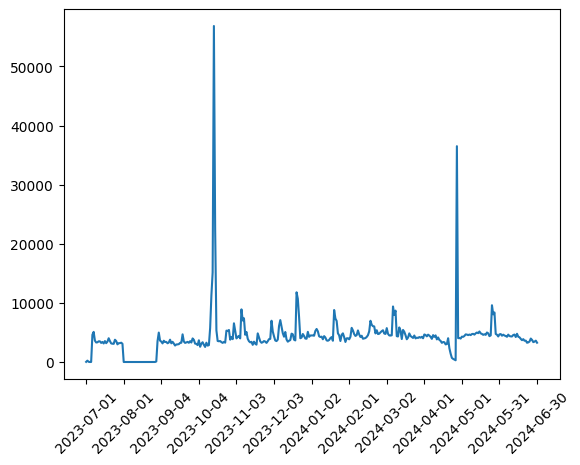

In [ ]:
plt.plot(plotdf.index, plotdf.values)
plt.xticks(ticks=plotdf.index[::len(plotdf)//12], rotation=45)
plt.show()

In [ ]:
# combining the data
dfc = df.copy()

dfc = dfc.drop(columns = ['fsn_id', 'order_id', 'order_item_id', 'cust_id', 'pincode'])

cat_cols = dfc.select_dtypes(exclude=['number']).columns.tolist()

num_cols = dfc.select_dtypes(include=['number']).columns.tolist()

# Original shape: (1531465, 39)
# Aggregated shape: (18235, 28)

if 'order_date' in cat_cols:
    cat_cols.remove('order_date')
if 'product_analytic_vertical' in cat_cols:
    cat_cols.remove('product_analytic_vertical')

agg_dict = {}
for col in num_cols:
    agg_dict[col] = 'mean'
for col in cat_cols:
    agg_dict[col] = lambda x: x.mode()[0] if not x.mode().empty else np.nan

agg_df = dfc.groupby(['order_date', 'product_analytic_vertical']).agg(agg_dict).reset_index()

row_counts = dfc.groupby(['order_date', 'product_analytic_vertical']).size().reset_index(name='num_orders')

agg_df = pd.merge(agg_df, row_counts, on=['order_date', 'product_analytic_vertical'], how='left')

print(f"Original shape: {df.shape}")
print(f"Aggregated shape: {agg_df.shape}")

agg_df

Original shape: (1531465, 39)
Aggregated shape: (18235, 35)


,order_date,product_analytic_vertical,gmv,units,deliverybdays,deliverycdays,sla,product_mrp,product_procurement_sla,list_p,...,NPS,stock_index,payweek,order_payment_type,week_start,week_end,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,num_orders
0,2023-07-01,AudioMP3Player,417.000000,1.000000,0.000000,0.000000,4.000000,1149.500000,2.000000,417.000000,...,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,EntertainmentSmall,AudioMP3Player,2
1,2023-07-01,BoomBox,2950.000000,1.000000,0.000000,0.000000,6.000000,3299.000000,5.000000,2950.000000,...,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,EntertainmentSmall,HomeAudio,1
2,2023-07-01,CameraStorageMemoryCard,299.000000,1.000000,0.000000,0.000000,7.000000,400.000000,1.000000,299.000000,...,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,CameraAccessory,CameraStorage,1
3,2023-07-01,GamePad,1213.500000,1.000000,0.000000,0.000000,4.000000,4499.000000,3.000000,1213.500000,...,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,GamingHardware,GamingAccessory,2
4,2023-07-01,GamingMouse,385.000000,1.000000,0.000000,0.000000,10.000000,699.000000,4.000000,385.000000,...,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,GamingHardware,GamingAccessory,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18230,2024-06-30,Telescope,2650.000000,1.000000,2.000000,2.500000,4.500000,6000.000000,1.000000,2650.000000,...,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,CameraAccessory,CameraAccessory,2
18231,2024-06-30,VideoGlasses,843.856061,1.037879,3.363636,4.136364,6.484848,2964.537879,2.151515,817.833333,...,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,EntertainmentSmall,TVVideoSmall,132
18232,2024-06-30,VideoPlayer,2649.127660,1.000000,3.404255,4.148936,5.702128,3937.000000,1.893617,2649.127660,...,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,EntertainmentSmall,TVVideoSmall,47
18233,2024-06-30,VoiceRecorder,1682.166667,1.000000,3.666667,4.500000,5.166667,3415.833333,2.666667,1682.166667,...,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,EntertainmentSmall,HomeAudio,6


In [ ]:
if 'order_date' in cat_cols:
    cat_cols.remove('order_date')
if 'product_analytic_sub_category' in cat_cols:
    cat_cols.remove('product_analytic_sub_category')

agg_dict = {}


# For numerical columns, use mean
for col in num_cols:
    agg_dict[col] = 'mean'
# For categorical columns, use mode
for col in cat_cols:
    agg_dict[col] = lambda x: x.mode()[0] if not x.mode().empty else np.nan

# Create a new DataFrame aggregated by order_date and product_analytic_sub_category
agg_df2 = dfc.groupby(['order_date', 'product_analytic_sub_category']).agg(agg_dict).reset_index()

# Calculate the count of rows that were combined for each group
row_counts = dfc.groupby(['order_date', 'product_analytic_sub_category']).size().reset_index(name='num_orders')

# Merge this count back into the aggregated DataFrame
agg_df2 = pd.merge(agg_df2, row_counts, on=['order_date', 'product_analytic_sub_category'], how='left')

print(f"Original shape: {dfc.shape}")
print(f"Aggregated shape: {agg_df2.shape}")

Original shape: (1531465, 33)
Aggregated shape: (4385, 34)


,order_date,product_analytic_sub_category,gmv,units,deliverybdays,deliverycdays,sla,product_mrp,product_procurement_sla,list_p,...,sale_day,NPS,stock_index,payweek,order_payment_type,week_start,week_end,product_analytic_super_category,product_analytic_category,num_orders
0,2023-07-01,AudioMP3Player,417.000000,1.000000,0.000000,0.000000,4.000000,1149.500000,2.000000,417.000000,...,0.0,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,EntertainmentSmall,2
1,2023-07-01,CameraStorage,299.000000,1.000000,0.000000,0.000000,7.000000,400.000000,1.000000,299.000000,...,0.0,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,CameraAccessory,1
2,2023-07-01,Game,1299.500000,1.000000,0.000000,0.000000,5.000000,3649.000000,5.000000,1299.500000,...,0.0,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,GameCDDVD,2
3,2023-07-01,GamingAccessory,937.333333,1.000000,0.000000,0.000000,6.000000,3232.333333,3.333333,937.333333,...,0.0,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,GamingHardware,3
4,2023-07-01,HomeAudio,2746.333333,1.000000,0.000000,0.000000,4.333333,3249.666667,4.666667,2746.333333,...,0.0,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,EntertainmentSmall,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4380,2024-06-30,GamingConsole,11064.818182,1.000000,2.766234,3.376623,4.818182,12987.259740,15.818182,11064.818182,...,0.0,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,GamingHardware,77
4381,2024-06-30,HomeAudio,2270.541899,1.000000,2.910615,3.575419,4.882682,3571.491620,2.575419,2270.541899,...,0.0,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,EntertainmentSmall,179
4382,2024-06-30,HomeTheatre,4110.000000,1.000000,3.080000,3.720000,5.240000,5686.040000,2.480000,4110.000000,...,0.0,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,EntertainmentSmall,25
4383,2024-06-30,Speaker,1445.206298,1.003257,3.026059,3.691640,4.990228,2460.769815,2.450597,1443.655809,...,0.0,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,EntertainmentSmall,921


In [ ]:
# First, drop the product_analytic_sub_category column
dfc = dfc.drop('product_analytic_sub_category', axis=1)

# Remove the grouping columns from the lists
if 'order_date' in cat_cols:
    cat_cols.remove('order_date')
if 'product_analytic_category' in cat_cols:
    cat_cols.remove('product_analytic_category')

agg_dict = {}
# For numerical columns, use mean
for col in num_cols:
    agg_dict[col] = 'mean'
# For categorical columns, use mode
for col in cat_cols:
    agg_dict[col] = lambda x: x.mode()[0] if not x.mode().empty else np.nan

# Create a new DataFrame aggregated by order_date and product_analytic_category
agg_df2 = dfc.groupby(['order_date', 'product_analytic_category']).agg(agg_dict).reset_index()

# Calculate the count of rows that were combined for each group
row_counts = dfc.groupby(['order_date', 'product_analytic_category']).size().reset_index(name='num_orders')

# Merge this count back into the aggregated DataFrame
agg_df2 = pd.merge(agg_df2, row_counts, on=['order_date', 'product_analytic_category'], how='left')

print(f"Original shape: {dfc.shape}")
print(f"Aggregated shape: {agg_df2.shape}")

agg_df2

Original shape: (1531465, 32)
Aggregated shape: (1708, 33)


,order_date,product_analytic_category,gmv,units,deliverybdays,deliverycdays,sla,product_mrp,product_procurement_sla,list_p,...,Other,sale_day,NPS,stock_index,payweek,order_payment_type,week_start,week_end,product_analytic_super_category,num_orders
0,2023-07-01,CameraAccessory,299.000000,1.000000,0.000000,0.000000,7.000000,400.000000,1.000000,299.000000,...,0.0,0.0,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,1
1,2023-07-01,EntertainmentSmall,716.047619,1.142857,0.095238,0.095238,3.571429,1336.523810,3.142857,701.904762,...,0.0,0.0,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,21
2,2023-07-01,GameCDDVD,1299.500000,1.000000,0.000000,0.000000,5.000000,3649.000000,5.000000,1299.500000,...,0.0,0.0,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,2
3,2023-07-01,GamingHardware,937.333333,1.000000,0.000000,0.000000,6.000000,3232.333333,3.333333,937.333333,...,0.0,0.0,54.599588,1177.0,1.0,Prepaid,2023-06-26,2023-07-02,CE,3
4,2023-07-03,Camera,11617.500000,1.000000,0.750000,0.750000,2.625000,16183.000000,2.625000,11617.500000,...,0.0,0.0,54.599588,1177.0,0.0,Prepaid,2023-07-03,2023-07-09,CE,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,2024-06-30,Camera,20821.461988,1.029240,2.578947,3.128655,3.970760,28207.333333,2.479532,20315.058480,...,0.0,0.0,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,171
1704,2024-06-30,CameraAccessory,1579.733467,1.022044,3.318637,4.040080,5.847695,2652.440882,2.713427,1563.717435,...,0.0,0.0,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,499
1705,2024-06-30,EntertainmentSmall,1666.602571,1.007267,3.126328,3.807155,5.428731,3055.323086,2.489100,1662.709894,...,0.0,0.0,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,1789
1706,2024-06-30,GameCDDVD,1794.106164,1.030822,2.215753,2.780822,4.181507,2723.023973,136.345890,1789.948630,...,0.0,0.0,50.516687,1194.0,0.0,COD,2024-06-24,2024-06-30,CE,292


# EDA

In [ ]:
df = pd.read_csv('Data/reduced_dataset_fixed.csv')

In [ ]:
investment_cols = ['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other']

## Correlations

In [ ]:
holiday_count = df.groupby('Month')['holiday_week'].sum().reset_index()
sale_count = df.groupby('Month')['sale_day'].sum().reset_index()

month_data = holiday_count.merge(sale_count, on='Month')
month_data.rename(columns={'holiday_week': 'Holiday_Days', 'sale_day': 'Sale_Days'}, inplace=True)

monthly_investments = df.groupby('Month')[investment_cols].first().reset_index()
monthly_data = monthly_investments.merge(month_data, on='Month')

monthly_investment = df.groupby('Month')[investment_cols].first().reset_index()

correlation_matrix = monthly_investment[investment_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Monthly Investments')
plt.tight_layout()
plt.show()

Plotting Group 1: ['Total Investment', 'Sponsorship', 'Content Marketing', 'SEM']


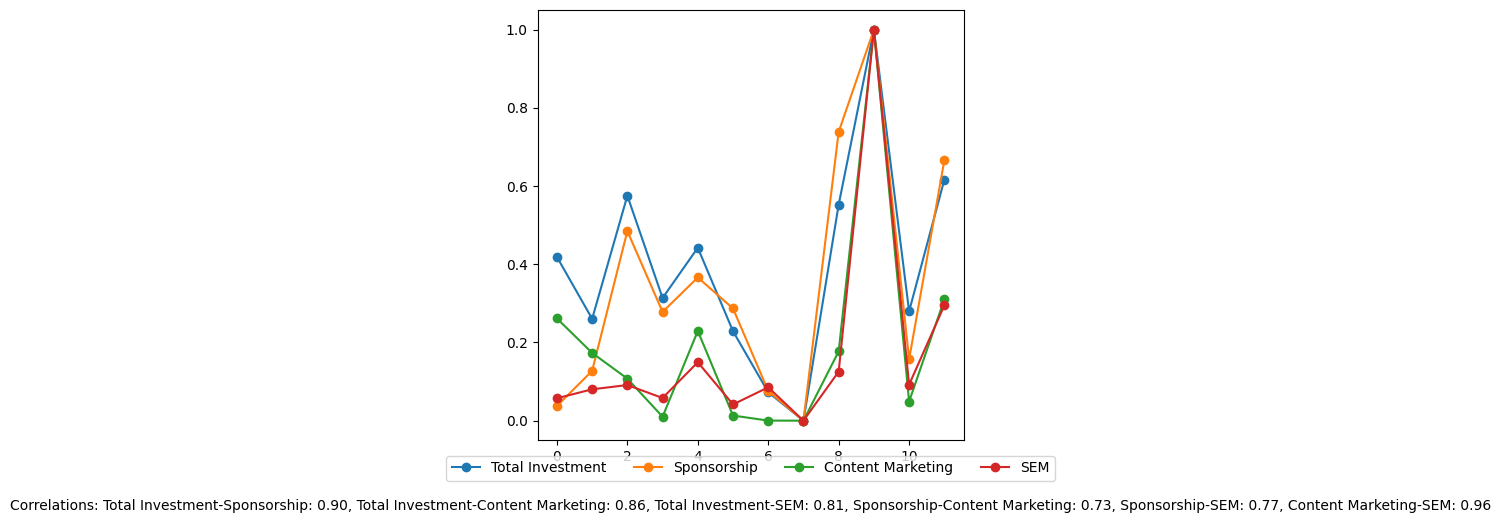

Plotting Group 2: ['Digital', 'Content Marketing', 'SEM']


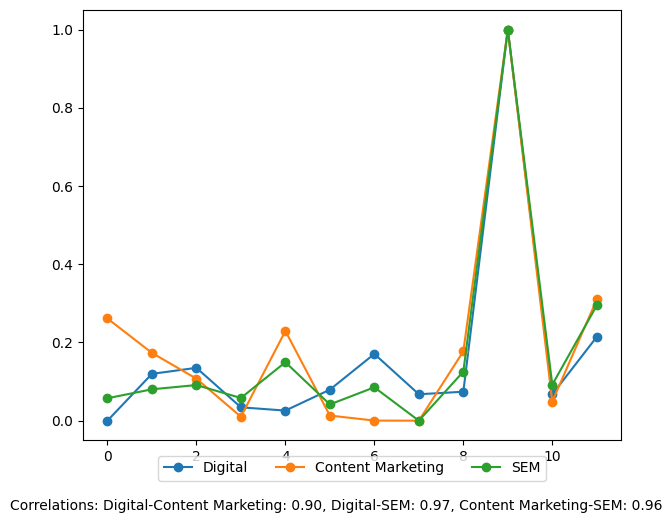

Plotting Group 3: ['Online marketing', ' Affiliates']


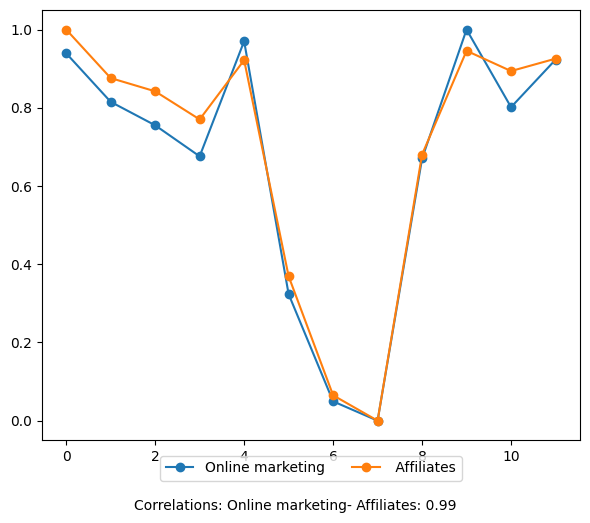

Plotting Group 4: ['Radio', 'Other']


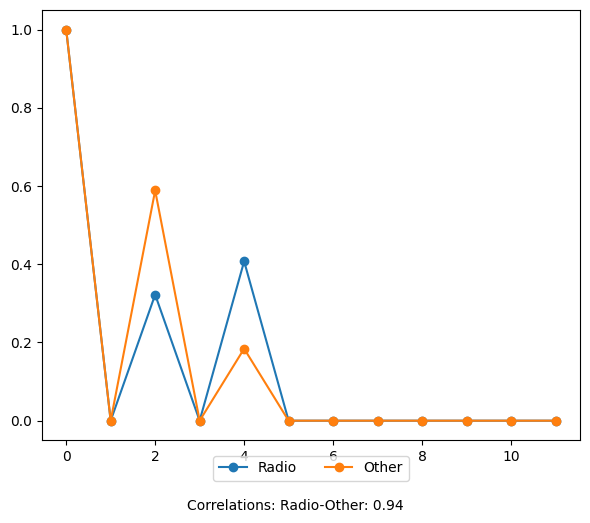

In [ ]:
monthly_investment = df.groupby('Month')[investment_cols].first().reset_index()

correlation_matrix = monthly_investment[investment_cols].corr()

def normalize_data(data):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

def find_correlated_groups(corr_matrix, threshold=0.75):
    groups = []
    used_columns = set()

    for col in corr_matrix.columns:
        if col in used_columns:
            continue
        correlated_cols = corr_matrix.index[corr_matrix[col] > threshold].tolist()
        if len(correlated_cols) > 1:
            group = correlated_cols
            groups.append(group)
            used_columns.update(group)

    return groups

def plot_correlated_group(data, group, corr_matrix):
    normalized_data = normalize_data(data[group])

    plt.figure(figsize=(6, 5))
    for col in group:
        plt.plot(normalized_data.index, normalized_data[col], marker='o', label=col)

    legend_labels = []
    for i, col1 in enumerate(group):
        for col2 in group[i+1:]:
            corr_value = corr_matrix.loc[col1, col2]
            legend_labels.append(f"{col1}-{col2}: {corr_value:.2f}")

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=len(group))
    plt.figtext(0.5, -0.03, "Correlations: " + ", ".join(legend_labels), ha="center", fontsize=10)

    plt.tight_layout()
    plt.show()

groups = find_correlated_groups(correlation_matrix, threshold=0.8)

for i, group in enumerate(groups):
    print(f"Plotting Group {i+1}: {group}")
    plot_correlated_group(monthly_investment, group, correlation_matrix)

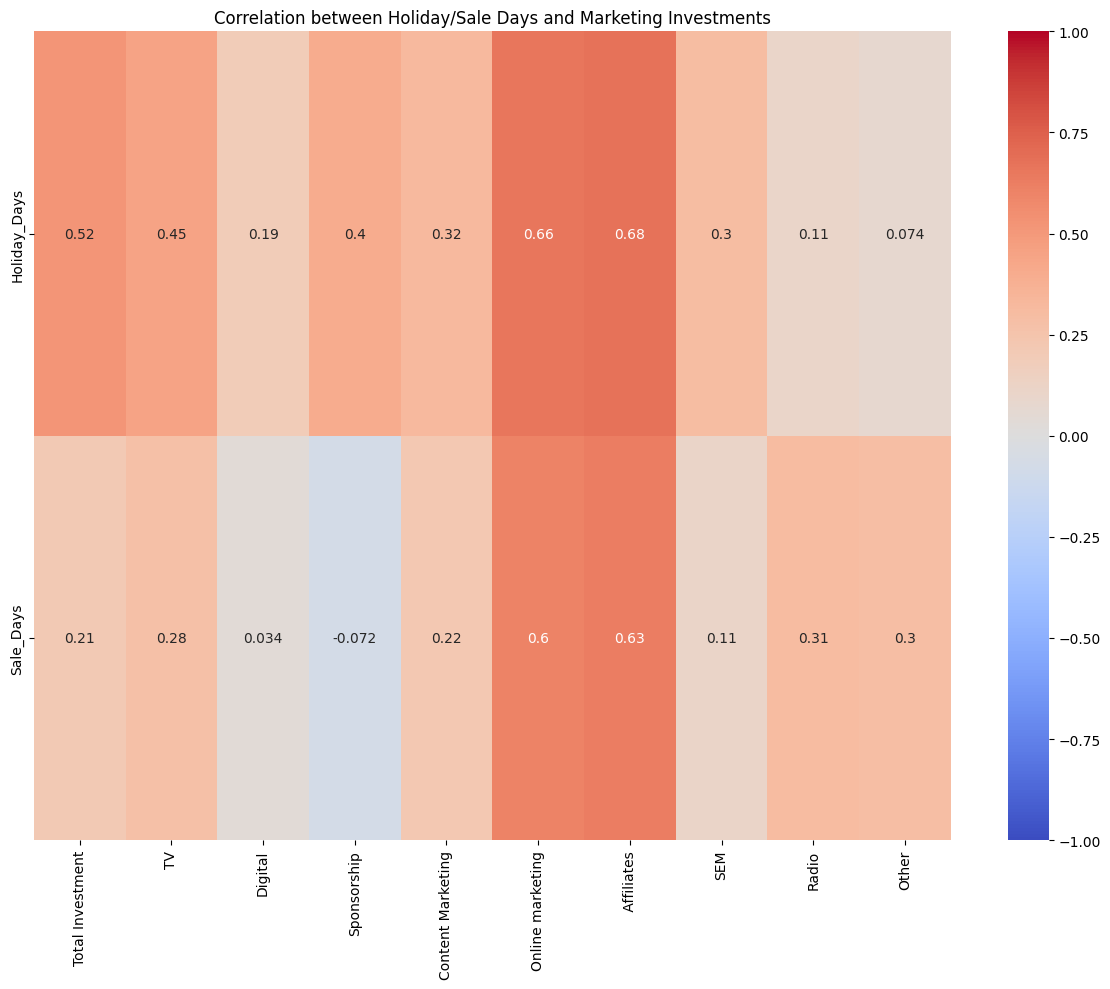

In [ ]:
correlation_matrix = monthly_data[investment_cols + ['Holiday_Days', 'Sale_Days']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix.loc[['Holiday_Days', 'Sale_Days'], investment_cols],
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Holiday/Sale Days and Marketing Investments')
plt.tight_layout()
plt.show()

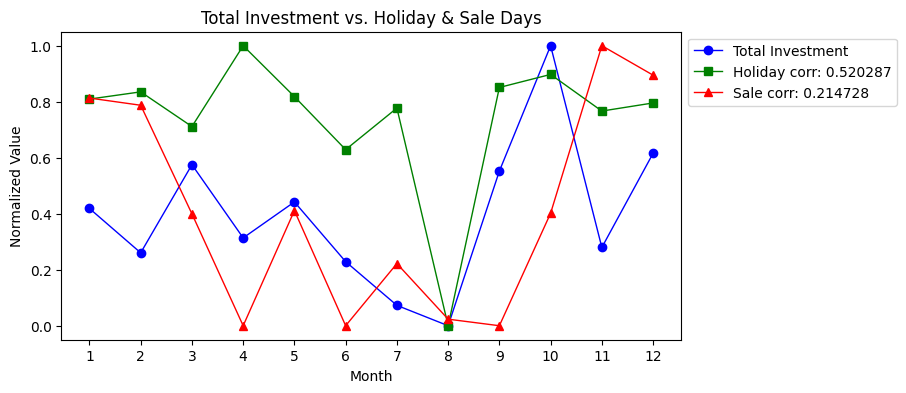

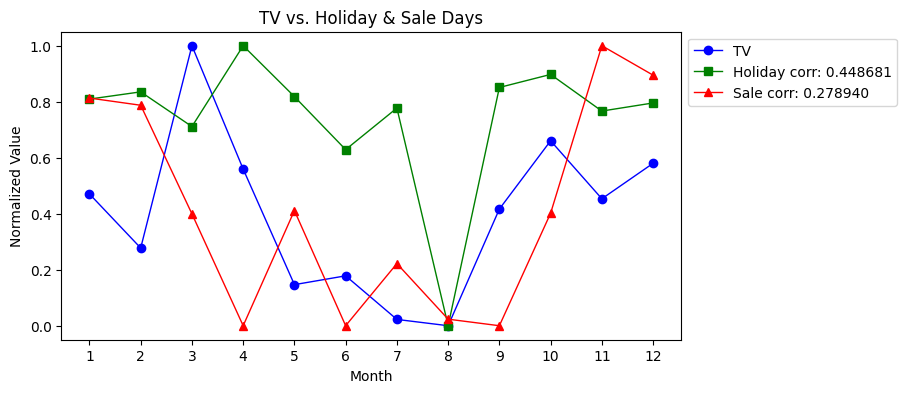

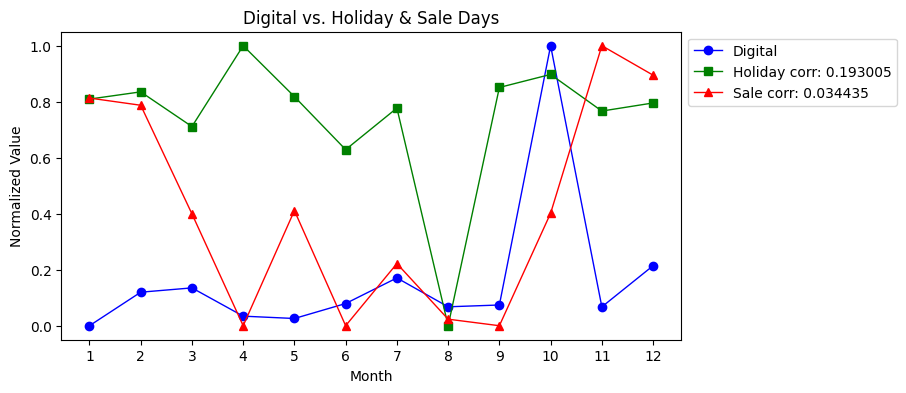

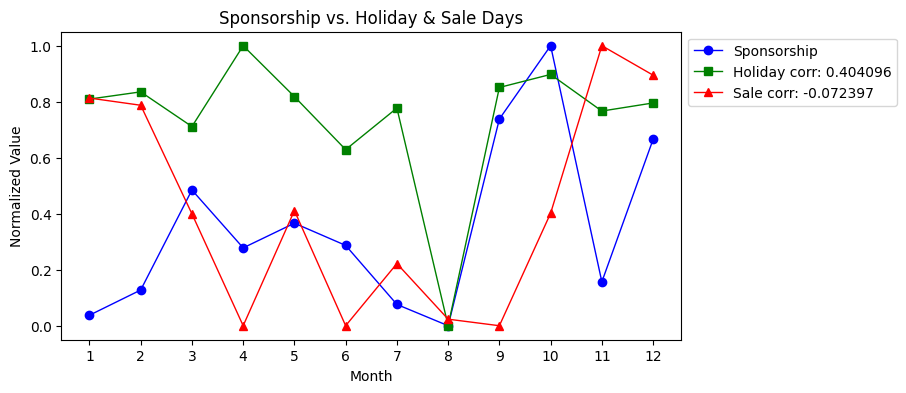

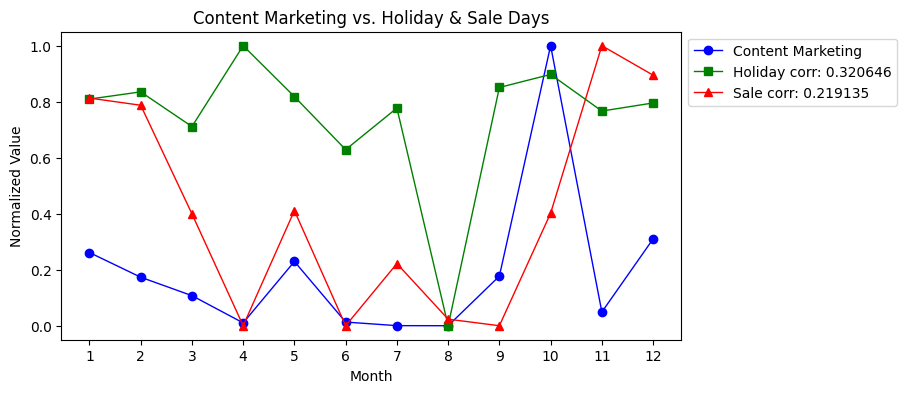

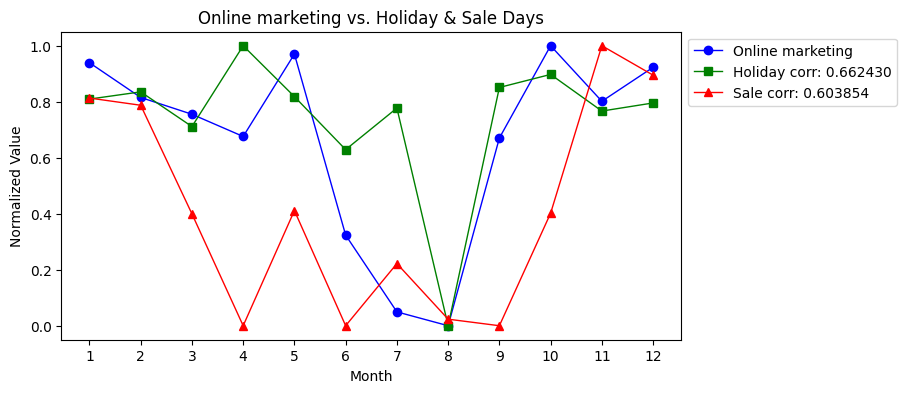

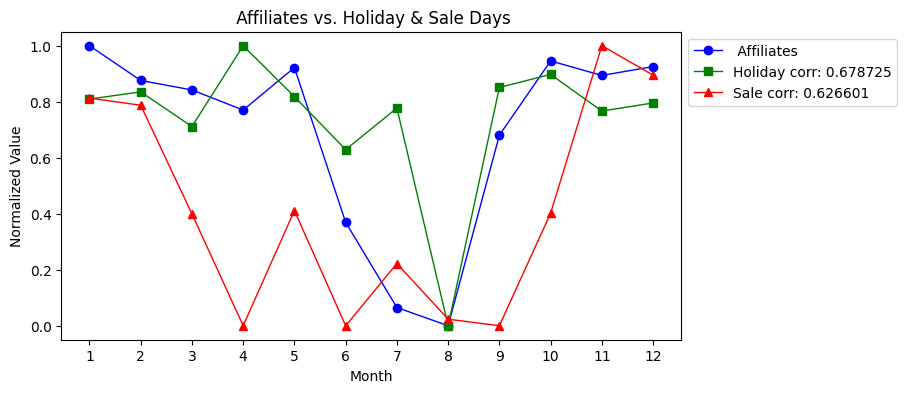

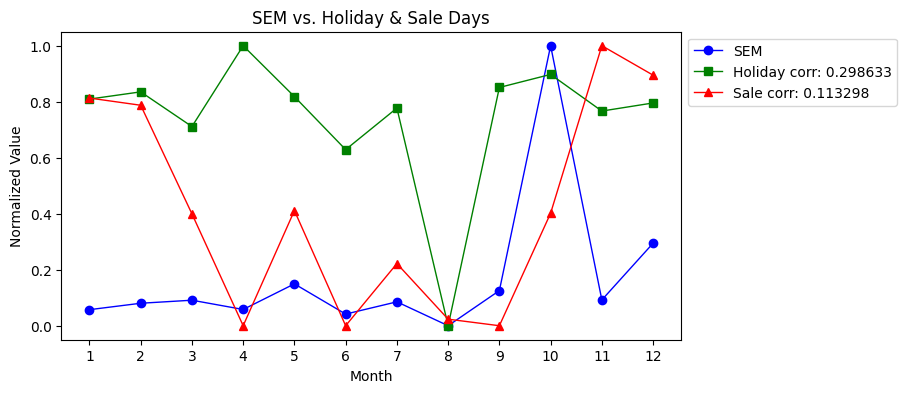

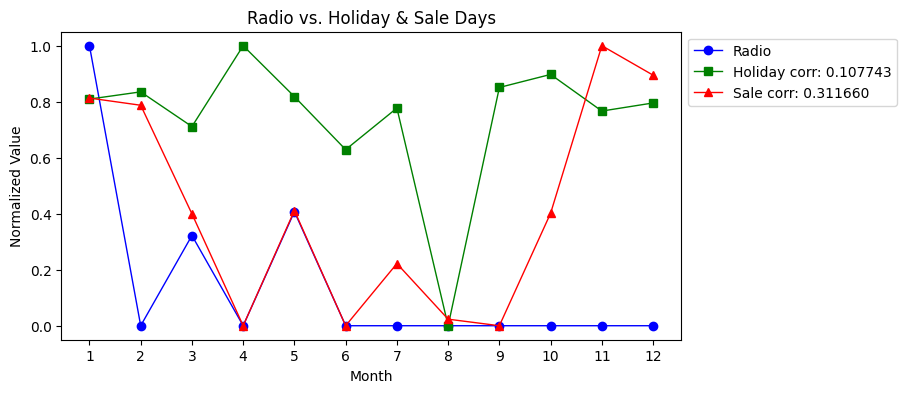

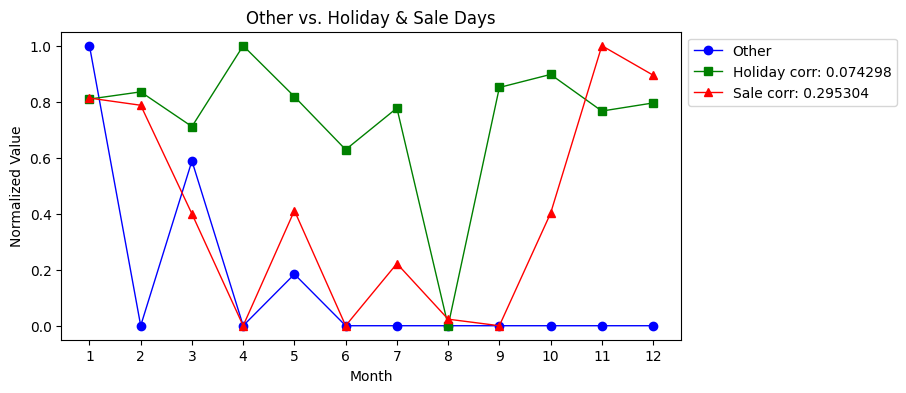

In [ ]:
for col in investment_cols:
    min_val = monthly_data[col].min()
    max_val = monthly_data[col].max()
    monthly_data[f'{col}_norm'] = (monthly_data[col] - min_val) / (max_val - min_val)

min_holiday = monthly_data['Holiday_Days'].min()
max_holiday = monthly_data['Holiday_Days'].max()
monthly_data['Holiday_Days_norm'] = (monthly_data['Holiday_Days'] - min_holiday) / (max_holiday - min_holiday)

min_sale = monthly_data['Sale_Days'].min()
max_sale = monthly_data['Sale_Days'].max()
monthly_data['Sale_Days_norm'] = (monthly_data['Sale_Days'] - min_sale) / (max_sale - min_sale)

for col in investment_cols:
    h_corr = correlation_matrix.loc[col, 'Holiday_Days_norm']
    s_corr = correlation_matrix.loc[col, 'Sale_Days_norm']

    plt.figure(figsize=(8, 4))

    plt.plot(monthly_data['Month'], monthly_data[f'{col}_norm'], 'o-', color='blue', linewidth=1,
            label=f'{col}')

    plt.plot(monthly_data['Month'], monthly_data['Holiday_Days_norm'], 's-', color='green',
            linewidth=1, label=f'Holiday corr: {h_corr:2f}')
    plt.plot(monthly_data['Month'], monthly_data['Sale_Days_norm'], '^-', color='red',
            linewidth=1, label=f'Sale corr: {s_corr:2f}')


    plt.title(f'{col} vs. Holiday & Sale Days')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel('Month')
    plt.ylabel('Normalized Value')

    plt.xticks(monthly_data['Month'])

    # plt.tight_layout()
    plt.show()